In [48]:
import pandas as pd
from ydata_profiling import ProfileReport

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import joblib
import warnings
warnings.filterwarnings('ignore')

### Исследовательский анализ данных

In [4]:
data_path = "../data/pricerunner_aggregate.csv"

In [25]:
df = pd.read_csv(data_path)
display(df.tail())
df.info()

,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
35306,47350,smeg fab28 60cm retro style right hand hinge f...,59,47517,Smeg FAB28 Cream,2623,Fridges
35307,47351,smeg fab28 60cm retro style left hand hinge fr...,59,47518,Smeg FAB28 Red,2623,Fridges
35308,47352,smeg fab28 60cm retro style left hand hinge fr...,59,47519,Smeg FAB28 Pink,2623,Fridges
35309,47355,candy 60cm built under larder fridge cru160nek,125,47524,Candy CRU16.0,2623,Fridges
35310,47358,neff k4316x7gb built under larder fridge,179,47525,Neff K4316,2623,Fridges


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Product ID       35311 non-null  int64 
 1   Product Title    35311 non-null  object
 2    Merchant ID     35311 non-null  int64 
 3    Cluster ID      35311 non-null  int64 
 4    Cluster Label   35311 non-null  object
 5    Category ID     35311 non-null  int64 
 6    Category Label  35311 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.9+ MB


In [24]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

По общему отчету видно, что в данных нет пропущенных значений, дубликатов и для предсказания принадлежности к категории стоит использовать переменную Product Title т.к. она содержит большое кол-во информации о продукте.

In [14]:
df.columns

Index(['Product ID', 'Product Title', ' Merchant ID', ' Cluster ID',
       ' Cluster Label', ' Category ID', ' Category Label'],
      dtype='object')

<AxesSubplot:xlabel=' Category Label'>

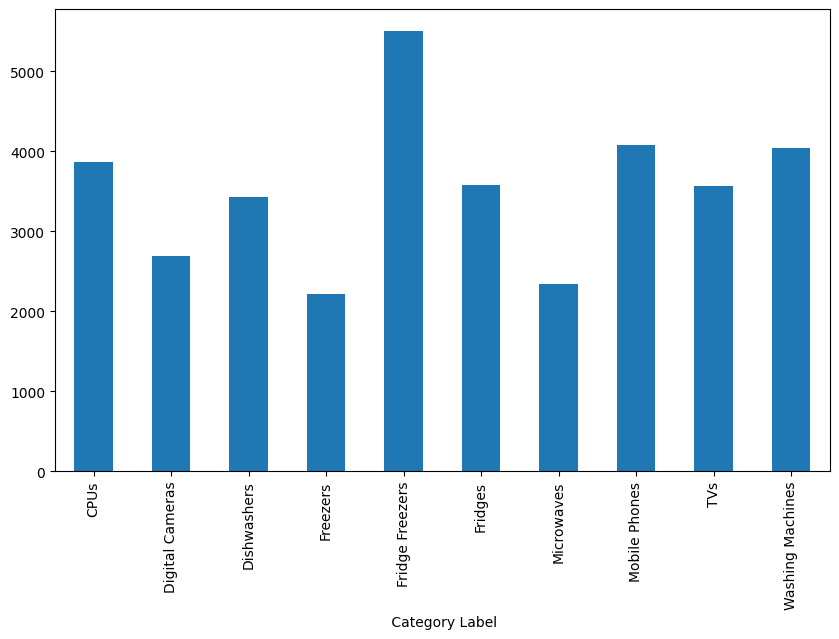

In [30]:
df.groupby([' Category Label'])[' Cluster ID'].count().plot(kind = 'bar', figsize = (10,6))

Достаточно близкое распределение наблюдений по категориям, самая популярная - холодильники с морозилками, самая непопулярная - морозилки без холодильников.

В ProfileReport были предоставлены облака слов для текстовых переменных, рассмотрим Product Title подробнее

<AxesSubplot:>

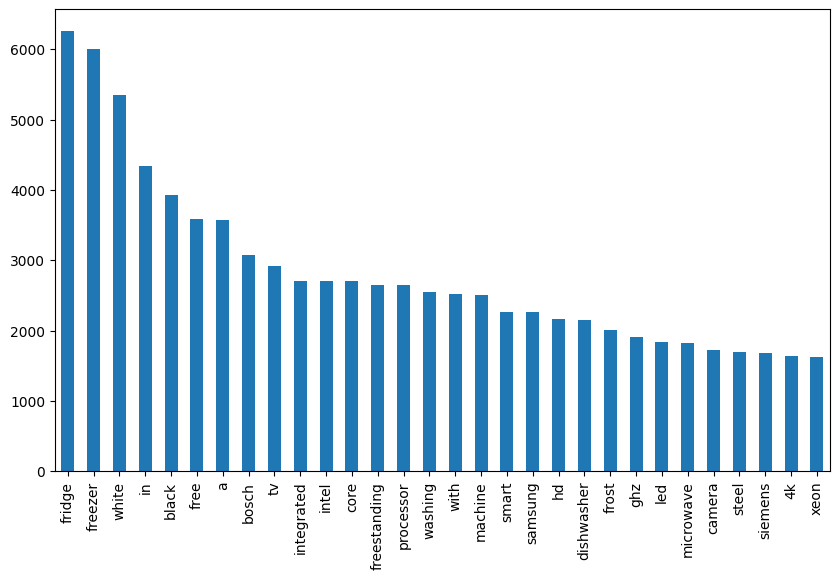

In [53]:
df['Product Title'].str.lower().str.split(' ', expand=True).stack().value_counts()[:30].plot.bar(figsize = (10,6))

### Обучение моделей

Подготовим 3 модели:

* логистическая регрессия
* Decision Tree
* Random Forest

В качестве метрики будем использовать accuracy, так как классы достаточно сбалансированные

К признаку Product Title для преобразования в числовой формат будем применять TF-IDF, он будет учитывать важность слов в тексте и их уникальность по всем данным.

#### Логистическая регрессия

In [39]:
logreg = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', LogisticRegression(max_iter=800))
])

x = df['Product Title'].str.lower()
y = df[' Category Label']

scores_lg = cross_val_score(logreg, x, y, cv=5, scoring='accuracy')
logreg.fit(x, y)
print('Accuracy of Logistic Regression:', round(scores_lg.mean(),5))

Accuracy of Logistic Regression: 0.9433884456086506


#### Decision Tree

In [51]:
dstree = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', DecisionTreeClassifier(min_samples_leaf=8))
])

x = df['Product Title'].str.lower()
y = df[' Category Label']

scores_dt = cross_val_score(dstree, x, y, cv=5, scoring='accuracy')
dstree.fit(x, y)
print('Accuracy of Decision Tree:', round(scores_dt.mean(), 5))

Accuracy of Decision Tree: 0.90207


#### Random Forest

In [52]:
forest = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', RandomForestClassifier(n_estimators=500, min_samples_leaf=2, n_jobs=-1))
])

x = df['Product Title'].str.lower()
y = df[' Category Label']

scores_rf = cross_val_score(forest, x, y, cv=5, scoring='accuracy')
forest.fit(x, y)
print('Accuracy of Random Forest:', round(scores_rf.mean(), 5))

Accuracy of Decision Tree: 0.92351


#### Ранжирование по результатам полученной accuracy:

1. логистическая регрессия
2. Random Forest
3. Decision Tree

Соответственно за определение категории логистической регрессией будем брать 15 кредитов, случайным лесом 10 и деревом решений 5. Сохраним модели.

In [54]:
joblib.dump(logreg, '../models/logreg.joblib')
joblib.dump(dstree, '../models/ds_tree.joblib')
joblib.dump(forest, '../models/rd_forest.joblib')

['../models/rd_forest.joblib']